In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
try:
    import torch  # type: ignore[import]
    import torch.nn as nn  # type: ignore[import]
    from torch.utils.data import TensorDataset, DataLoader, random_split  # type: ignore[import]
except ImportError as exc:
    raise ImportError(
        "PyTorch is required for this notebook. Please install torch."
    ) from exc
try:
    from sklearn.preprocessing import MinMaxScaler  # type: ignore[import]
except ImportError as exc:
    raise ImportError(
        "scikit-learn is required for this notebook. Please install scikit-learn."
    ) from exc

torch.manual_seed(42)

import sys
root_dir = os.path.abspath("..")
if root_dir not in sys.path:
    sys.path.append(root_dir)
# print("Project root in sys.path:", root_dir)

from src.config import (
    CMAPSS_DATASETS,
    MAX_RUL,
    SEQUENCE_LENGTH,
    HIDDEN_SIZE,
    NUM_LAYERS,
    OUTPUT_SIZE,
    LEARNING_RATE,
    NUM_EPOCHS,
    GLOBAL_FEATURE_COLS,
    GLOBAL_DROP_COLS 
)

from src.data_loading import load_cmapps_subset
from src.additional_features import create_physical_features
from src.world_model_training import train_world_model_global

In [34]:
import importlib
import src.world_model_training as wmt

importlib.reload(wmt)

from src.data_loading import load_cmapps_global
from src.additional_features import create_physical_features
from src.config import GLOBAL_FEATURE_COLS, GLOBAL_DROP_COLS
from src.world_model_training import train_world_model_global

# 1) globale Trainingsdaten bauen (Pseudo-Code, an deine Signaturen anpassen)
dfs = []
for fd_id in ["FD001", "FD002", "FD003", "FD004"]:
    df_train, _, _ = load_cmapps_subset(fd_id)  # ggf. add_rul=True etc.
    df_train = create_physical_features(df_train)
    df_train["FD_ID"] = fd_id
    dfs.append(df_train)

df_train_global = pd.concat(dfs, ignore_index=True)

# 2) Featureliste definieren (wie beim globalen LSTM)
numeric_cols = df_train_global[GLOBAL_FEATURE_COLS].select_dtypes(
    include=["number"]
).columns.tolist()
feature_cols = numeric_cols

# 5) Train World Model
model_world, hist_world = train_world_model_global(
    df_train_global=df_train_global,
    feature_cols=feature_cols,
    past_len=30,
    horizon=20,
    hidden_size=64,
    num_layers=2,
    dropout=0.1,
    batch_size=128,
    num_epochs=25,
    lr=5e-4,
    val_split=0.1,
    early_stopping_patience=5,
    checkpoint_dir="results/world_model",
)


New columns successfully added. Current number of columns: 32
   Effizienz_HPC_Proxy  EGT_Drift  Fan_HPC_Ratio  RUL
0             0.941013        0.2       0.403737  125
1             0.943169        0.2       0.403406  125
2             0.942554       -1.8       0.404505  125
3             0.943025        0.2       0.405834  125
4             0.942581        1.2       0.405831  125
[ConditionID] Found 7 unique (S1_r, S2_r, S3_r) combos in TRAIN.
[ConditionID] Train ConditionIDs: [0 1 2 3 4 5 6]
[ConditionID] Test  ConditionIDs: [0 1 2 3 4 5 6]
New columns successfully added. Current number of columns: 32
   Effizienz_HPC_Proxy  EGT_Drift  Fan_HPC_Ratio  RUL
0             0.940506        6.8       0.408741  125
1             0.941593        2.8       0.406364  125
2             0.934608      -18.2       0.427536  125
3             0.944099        1.8       0.405833  125
4             0.938646      -18.2       0.427022  125
New columns successfully added. Current number of columns: 32
 

In [36]:

# --- GLOBAL TEST ---
dfs_test = []

for fd_id in ["FD001", "FD002", "FD003", "FD004"]:
    df_train, df_test, rul_test = load_cmapps_subset(fd_id)

    # 1) MaxTime pro Unit im TEST berechnen
    max_cycles = (
        df_test.groupby("UnitNumber")["TimeInCycles"]
        .max()
        .rename("MaxTime")
        .reset_index()
    )
    df_test = df_test.merge(max_cycles, on="UnitNumber", how="left")

    # 2) RUL_last pro Unit aus rul_test bauen
    #    Wir gehen davon aus: rul_test ist in der Reihenfolge Unit 1..N
    units = (
        df_test[["UnitNumber"]]
        .drop_duplicates()
        .sort_values("UnitNumber")
        .reset_index(drop=True)
    )
    rul_df = pd.DataFrame({
        "UnitNumber": units["UnitNumber"].values,
        "RUL_last": rul_test.reshape(-1),
    })

    df_test = df_test.merge(rul_df, on="UnitNumber", how="left")

    # 3) RUL(t) = RUL_last + (MaxTime - TimeInCycles)
    df_test["RUL"] = df_test["RUL_last"] + (df_test["MaxTime"] - df_test["TimeInCycles"])

    # 4) Optional: RUL clamping wie im Training
    df_test["RUL"] = df_test["RUL"].clip(upper=MAX_RUL)

    # 5) Physikfeatures ergänzen
    df_test = create_physical_features(df_test)

    # 6) FD_ID hinzufügen
    df_test["FD_ID"] = fd_id

    dfs_test.append(df_test)

df_test_global = pd.concat(dfs_test, ignore_index=True)

print("df_test_global columns:", df_test_global.columns)
print(df_test_global[["FD_ID", "UnitNumber", "TimeInCycles", "MaxTime", "RUL"]].head())


New columns successfully added. Current number of columns: 33
   Effizienz_HPC_Proxy  EGT_Drift  Fan_HPC_Ratio    RUL
0             0.941903        0.3       0.405617  125.0
1             0.941083        1.3       0.403985  125.0
2             0.941997        1.3       0.404842  125.0
3             0.941000       -0.7       0.405550  125.0
4             0.942237       -1.7       0.404810  125.0
[ConditionID] Found 7 unique (S1_r, S2_r, S3_r) combos in TRAIN.
[ConditionID] Train ConditionIDs: [0 1 2 3 4 5 6]
[ConditionID] Test  ConditionIDs: [0 1 2 3 4 5 6]
New columns successfully added. Current number of columns: 33
   Effizienz_HPC_Proxy  EGT_Drift  Fan_HPC_Ratio    RUL
0             0.942084       31.9       0.404116  125.0
1             0.943055       26.9       0.410356  125.0
2             0.945699       -4.1       0.409100  125.0
3             0.939888       -5.1       0.407627  125.0
4             0.936330      -32.1       0.428286  125.0
New columns successfully added. Current

In [37]:
from src.world_model_training import compute_nasa_score_from_world_model

nasa_world_test = compute_nasa_score_from_world_model(
    model=model_world,
    df_global=df_test_global,   # unser manuell gebautes Test-DF
    feature_cols=feature_cols,  # dieselben Features wie beim Training
    past_len=30,
    horizon=20,
)

nasa_world_test

{'num_engines': 653,
 'mean_error': 1.6513976320555892,
 'mean_abs_error': 1.8968185261234207,
 'nasa_score_sum': 215.32450056863803,
 'nasa_score_mean': 0.3297465552352803}

In [2]:
# 1) globale Trainingsdaten bauen (Pseudo-Code, an deine Signaturen anpassen)
dfs = []
for fd_id in ["FD001", "FD002", "FD003", "FD004"]:
    df_train, _, _ = load_cmapps_subset(fd_id)  # ggf. add_rul=True etc.
    df_train = create_physical_features(df_train)
    df_train["FD_ID"] = fd_id
    dfs.append(df_train)

df_train_global = pd.concat(dfs, ignore_index=True)

# 2) Featureliste definieren (wie beim globalen LSTM)
numeric_cols = df_train_global[GLOBAL_FEATURE_COLS].select_dtypes(
    include=["number"]
).columns.tolist()
feature_cols = numeric_cols

# 3) World Model trainieren
model_world, hist_world = train_world_model_global(
    df_train_global=df_train_global,
    feature_cols=feature_cols,
    past_len=30,
    horizon=20,
    hidden_size=64,
    num_layers=2,
    dropout=0.1,
    num_epochs=20,
)

New columns successfully added. Current number of columns: 32
   Effizienz_HPC_Proxy  EGT_Drift  Fan_HPC_Ratio  RUL
0             0.941013        0.2       0.403737  125
1             0.943169        0.2       0.403406  125
2             0.942554       -1.8       0.404505  125
3             0.943025        0.2       0.405834  125
4             0.942581        1.2       0.405831  125
[ConditionID] Found 7 unique (S1_r, S2_r, S3_r) combos in TRAIN.
[ConditionID] Train ConditionIDs: [0 1 2 3 4 5 6]
[ConditionID] Test  ConditionIDs: [0 1 2 3 4 5 6]
New columns successfully added. Current number of columns: 32
   Effizienz_HPC_Proxy  EGT_Drift  Fan_HPC_Ratio  RUL
0             0.940506        6.8       0.408741  125
1             0.941593        2.8       0.406364  125
2             0.934608      -18.2       0.427536  125
3             0.944099        1.8       0.405833  125
4             0.938646      -18.2       0.427022  125
New columns successfully added. Current number of columns: 32
 

In [4]:
save_dir = "../results/world_model"
os.makedirs(save_dir, exist_ok=True)

# 1) Modell speichern (letzte Epoche oder bestes Modell, je nachdem)
model_path = os.path.join(save_dir, "world_model_global_last.pt")
torch.save(model_world.state_dict(), model_path)
print("Saved model to:", model_path)

# 2) Training-Historie speichern (optional, falls du die Kurve später plotten willst)
history_path = os.path.join(save_dir, "world_model_global_history.npy")
np.save(history_path, hist_world)
print("Saved history to:", history_path)

Saved model to: ../results/world_model\world_model_global_last.pt
Saved history to: ../results/world_model\world_model_global_history.npy


In [29]:
import importlib
import src.world_model_training as wmt

importlib.reload(wmt)

from src.world_model_training import (
    train_world_model_global,
    evaluate_world_model_global,
    plot_world_model_rul_rollout_for_unit,
    compute_nasa_score_from_world_model,
)

import src.data_loading as wmt

importlib.reload(wmt)

from src.data_loading import load_cmapps_global_test
from src.additional_features import create_physical_features

from src.data_loading import load_cmapps_global
from src.config import GLOBAL_FEATURE_COLS

df_train_global, df_test_global, global_scaler = load_cmapps_global()
print("df_train_global type:", type(df_train_global))
print("df_test_global  type:", type(df_test_global))

feature_cols = GLOBAL_FEATURE_COLS

[ConditionID] Found 7 unique (S1_r, S2_r, S3_r) combos in TRAIN.
[ConditionID] Train ConditionIDs: [0 1 2 3 4 5 6]
[ConditionID] Test  ConditionIDs: [0 1 2 3 4 5 6]
[ConditionID] Found 7 unique (S1_r, S2_r, S3_r) combos in TRAIN.
[ConditionID] Train ConditionIDs: [0 1 2 3 4 5 6]
[ConditionID] Test  ConditionIDs: [0 1 2 3 4 5 6]
df_train_global type: <class 'pandas.core.frame.DataFrame'>
df_test_global  type: <class 'dict'>


In [31]:
nasa_world_test = compute_nasa_score_from_world_model(
    model=model_world,
    df_global=df_train_global,   # jetzt wirklich ein DataFrame
    feature_cols=feature_cols,
    past_len=30,
    horizon=20,
)

KeyError: "['Effizienz_HPC_Proxy', 'EGT_Drift', 'Fan_HPC_Ratio'] not in index"

In [14]:
nasa_world = compute_nasa_score_from_world_model(
    model=model_world,
    df_global=df_train_global,     # oder eigener Test-DF
    feature_cols=feature_cols,
    past_len=30,
    horizon=20
)

nasa_world

{'num_engines': 709,
 'mean_error': 6.858334220514983,
 'mean_abs_error': 6.858334220514983,
 'nasa_score_sum': 698.6669233093717,
 'nasa_score_mean': 0.9854258438778162}

In [6]:
from src.world_model_training import evaluate_world_model_global

metrics_world = evaluate_world_model_global(
    model=model_world,
    df_eval_global=df_train_global,  # oder ein eigenes Eval-DF
    feature_cols=feature_cols,
    past_len=30,
    horizon=20,
)
metrics_world

[WorldModel-Eval] MSE: 21.9644, RMSE: 4.6866, samples: 147619


{'MSE': 21.964442146122497, 'RMSE': 4.686623747019009, 'num_samples': 147619}

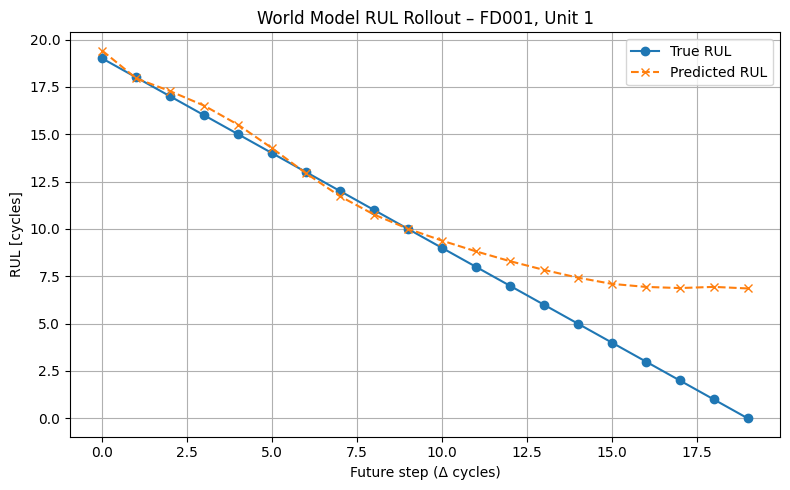

[WorldModel-Rollout] FD001, Unit 1 – MSE: 7.2005, RMSE: 2.6834


In [7]:
from src.world_model_training import plot_world_model_rul_rollout_for_unit

# Beispiel: FD001, Unit 1
plot_world_model_rul_rollout_for_unit(
    model=model_world,
    df_global=df_train_global,   # oder df_eval_global, aber mit FD_ID & RUL-Spalte
    feature_cols=feature_cols,
    fd_id="FD001",
    unit_number=1,
    past_len=30,
    horizon=20,
)